# 1. Wczytanie i eksploracja danych

In [2]:
! pip install covid19dh

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from covid19dh import covid19
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import shapiro
from sklearn.metrics import r2_score
from scipy.stats import probplot
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn import svm

In [4]:
world, src = covid19(verbose=False)

In [136]:
raw_data_shape = world.shape
raw_data_shape

(75556, 25)

In [6]:
world.head()

,id,date,confirmed,deaths,recovered,tests,vaccines,people_vaccinated,people_fully_vaccinated,hosp,...,iso_alpha_3,iso_alpha_2,iso_numeric,iso_currency,key_local,key_google_mobility,key_apple_mobility,key_jhu_csse,key_nuts,key_gadm
154733,0094b645,2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
154734,0094b645,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
154735,0094b645,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
154736,0094b645,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA
154737,0094b645,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,LCA,LC,662.0,XCD,NaN,NaN,NaN,LC,NaN,LCA


In [7]:
world.columns

Index(['id', 'date', 'confirmed', 'deaths', 'recovered', 'tests', 'vaccines',
       'people_vaccinated', 'people_fully_vaccinated', 'hosp', 'icu', 'vent',
       'school_closing', 'workplace_closing', 'cancel_events',
       'gatherings_restrictions', 'transport_closing',
       'stay_home_restrictions', 'internal_movement_restrictions',
       'international_movement_restrictions', 'information_campaigns',
       'testing_policy', 'contact_tracing', 'facial_coverings',
       'vaccination_policy', 'elderly_people_protection',
       'government_response_index', 'stringency_index',
       'containment_health_index', 'economic_support_index',
       'administrative_area_level', 'administrative_area_level_1',
       'administrative_area_level_2', 'administrative_area_level_3',
       'latitude', 'longitude', 'population', 'iso_alpha_3', 'iso_alpha_2',
       'iso_numeric', 'iso_currency', 'key_local', 'key_google_mobility',
       'key_apple_mobility', 'key_jhu_csse', 'key_nuts', 'key_g

Kolumny które możemy odrzucić na samym początku:
 - id
 - hosp, icu, vent: zmienne mówiące o liczbie pacjentów w szpitalach w różnym stanie. Nie są celem naszej analizy, a same w sobie stanowią skutek liczby zachorowań i ewentualnie polityki danego kraju, a nie jakąkolwiek ich przyczynę.
 - economic_support_index: mówi o tym jakie wsparcie ekonomiczne dla obywateli zostało udzielone, nie ma wpływu na liczbę zachorowań
 - administrative_area_level_[1-3]: nazwa obszaru z którego zostały zebrane dane, przy analizie globalnej nie ma to znaczenia, przy analizie lokalnej zestaw danych zostanie zawężony na podstawie tych kolumn
 - latitude, longitude: podobnie do powyższego, same w sobie nie stanowią żadnej informacji
 - iso_alpha_3, iso_alpha_2, iso_numeric: nazwa kraju w postaci kodu, nieistotna
 - iso_currency: waluta, nie ma wpływu
 - key_*: zmienne będące identyfikatorami regionów administracyjnych w różnych formatach
 - population: nie będziemy porównywać modeli pomiędzy państwami

In [8]:
columns_to_drop = [
    'id',
    'hosp',
    'icu',
    'vent',
    'latitude',
    'longitude',
    'economic_support_index',
    'population'
] + list(world.filter(regex='iso|administrative|key'))

columns_to_drop.remove('administrative_area_level_1')

world.drop(columns=columns_to_drop, axis=1, inplace=True)

In [9]:
world.shape

(190088, 26)

Po usunięciu nieistotnych kolumn, udało się zredukować liczbę zmiennych z 47 do 27.

In [10]:
spain = world[world.administrative_area_level_1 == 'Spain']
spain.reset_index(drop=True, inplace=True)

#### 1.x Sprawdzenie braków danych

In [11]:
world_nulls = 100 * world.isnull().sum() / world.shape[0]
spain_nulls = 100 * spain.isnull().sum() / spain.shape[0]

pd.DataFrame({
    'World': world_nulls,
    'Spain': spain_nulls
})

,World,Spain
date,0.000000,0.000000
confirmed,8.667038,1.187648
deaths,17.103657,4.869359
recovered,62.988721,92.280285
tests,58.750158,6.650831
vaccines,74.534952,64.726841
people_vaccinated,75.773852,64.251781
people_fully_vaccinated,77.011700,65.083135
school_closing,19.793990,6.175772
workplace_closing,19.817663,6.175772


Widzimy, że charakterystyka braków danych różni się w zależności od tego, czy rozważamy dane globalnie czy tylko dla Hiszpanii.

Widzimy, że wszystkie kolumny poza datą zawierają braki danych, w różnym stopniu.
- Dla wszystkich zmiennych opisujących poziom restrykcji, liczba braków danych oscyluje w okolicy 20%

**OPISAĆ WIĘCEJ O BRAKACH DANYCH**

Przyjrzyjmy się badanym cechom na wykresach.

# 2. Uzupełnienie braków danych (Hiszpania)

In [12]:
spain.shape

(842, 26)

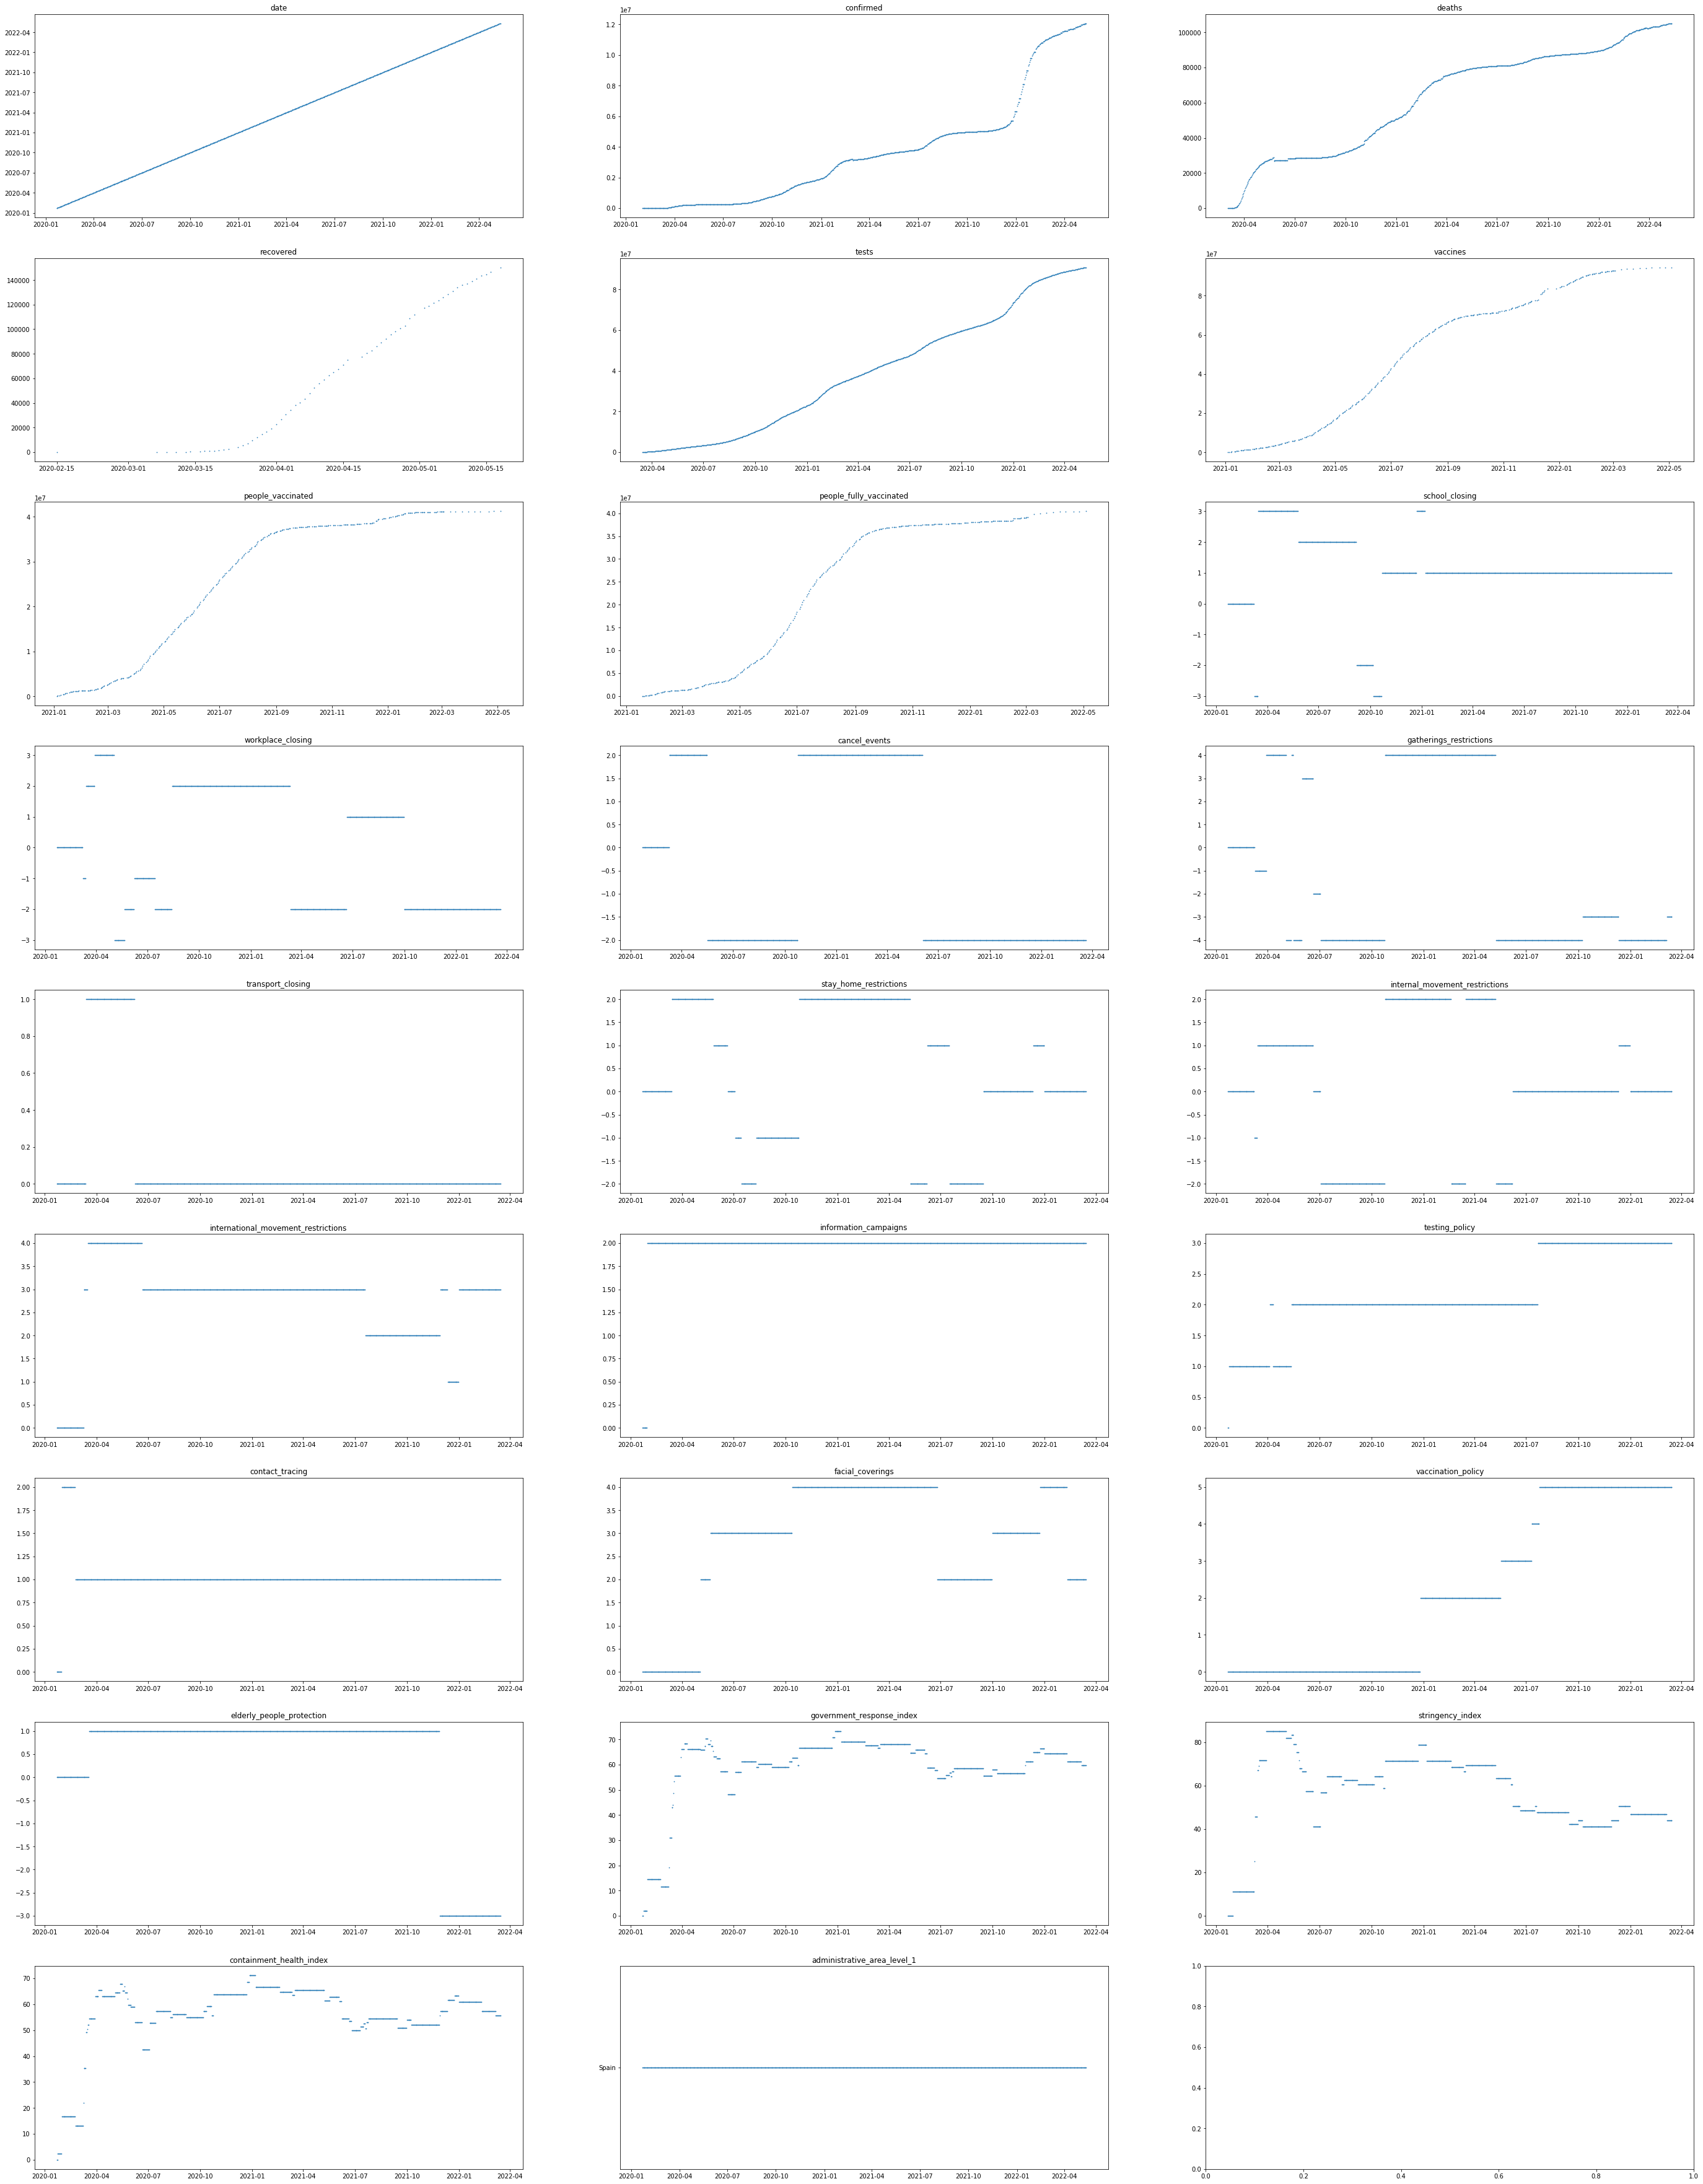

In [13]:
fig, ax = plt.subplots(9, 3, figsize=(48,64))

for it, col in enumerate(spain.columns):
    i = it // 3
    j = it % 3
    ax[i, j].scatter(spain['date'], spain[col], s=0.5)
    ax[i, j].set_title(col)

plt.show()

- Zauważyłem, że wszystkie braki danych dla kolumn opisujących restrykcje i antycovidową politykę kraju występują od dnia 16/03/2022. W moim odczuciu może to być spowodowane przez kilka rzeczy:
    - powszechnie zauważalny trend do zmniejszania obostrzeń w tym czasie
    - dane za ten okres mogły nie zostać jeszcze odpowiednio przetworzone i wprowadzone do zbioru z Covid Data Hub
    - dane mogą nie być już tak pieczołowicie gromadzone jak to miało miejsce wcześniej

  Biorąc pod uwagę powyższe czynniki oraz fakt, że omawiane braki stanowią niewiele ponad 5% całego zestawu, a zbadanie ich wpływu na liczbę zachorowań i zgonów uważam za istotne, zdecydowałem się usunąć obserwacje z okresu po 16/03/2022.

- vaccines, people_vaccinated, people_fully_vaccinated: braki w początkowym okresie pandemii, nie było wtedy szczepień więc można zastąpić 0

- recovered: dane są tylko z początkowego okresu, później już nie były zbierane. Zdecydowałem że ta kolumna jest do usunięcia

In [14]:
idx = spain[spain['date'] == '2022-03-16'].index
row_num = spain.index.get_loc(idx[0])
spain = spain.drop(spain.index[row_num:])

In [15]:
spain = spain.drop('recovered', axis=1)

Dla danych z kolumny deaths możemy zaobserwować dziwne zjawisko. W okresie letnich miesięcy 2020 mamy fragment gdzie całkowita liczba odnotowanych zgonów spada w czasie. Jest to niemożliwe, ponieważ mówimy o parametrze skumulowanym, a więc takim który może tylko rosnąć. Sprawdzimy, czy podobne sytuacje występują dla innych skumulowanych parametrów.

In [16]:
cumulative_cols = ['tests', 'confirmed', 'deaths', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated']

columns_with_error = []
for col in cumulative_cols:
    a = np.array(spain[col].dropna())
    if not np.all(a[:-1] <= a[1:]):
        columns_with_error.append(col)
print(columns_with_error)

['confirmed', 'deaths']


Widać, że opisany problem występuje w kolumnach 'confirmed' i 'deaths'. Dla pozostałych zmiennych skumulowanych, kolejne wartości są zawsze nie mniejsze od poprzednich. Pozostaje pytanie, jak postąpić z powyższym błędem. Zdecydowałem, że w miejscach gdzie wartości zaczynają spadać, zastąpię je ostatnim poprawnym odczytem.

In [17]:
for col in columns_with_error:
    a = np.array(spain[col])
    for i in range(1, spain.shape[0]):
        if a[i] < a[i-1]:
            a[i] = a[i-1]
    spain[col] = a

Zajmiemy się teraz brakami danych dla pozostałych cech. Duże braki danych występują dla zmiennych odpowiadających za szczepienia, ale wynika to z faktu że nie były one dostępne przez początkowy okres pandemii. W takiej sytuacji, naturalne wydaje się zastąpienie ich zerami, do momentu wystąpienia pierwszej wartości w tych kolumnach. Tak samo postępujemy dla kolumn 'confirmed' i 'deaths'.

In [18]:
spain[cumulative_cols[1:]] = spain[cumulative_cols[1:]].interpolate('zero', fill_value=0, limit_direction='backward')

In [19]:
100 * spain.isnull().sum() / spain.shape[0]

date                                   0.000000
confirmed                              0.000000
deaths                                 0.000000
tests                                  6.760204
vaccines                               0.637755
people_vaccinated                      0.637755
people_fully_vaccinated                0.637755
school_closing                         0.000000
workplace_closing                      0.000000
cancel_events                          0.000000
gatherings_restrictions                0.000000
transport_closing                      0.000000
stay_home_restrictions                 0.000000
internal_movement_restrictions         0.000000
international_movement_restrictions    0.000000
information_campaigns                  0.000000
testing_policy                         0.000000
contact_tracing                        0.000000
facial_coverings                       0.000000
vaccination_policy                     0.000000
elderly_people_protection              0

In [20]:
spain.tail(10)

,date,confirmed,deaths,tests,vaccines,people_vaccinated,people_fully_vaccinated,school_closing,workplace_closing,cancel_events,...,information_campaigns,testing_policy,contact_tracing,facial_coverings,vaccination_policy,elderly_people_protection,government_response_index,stringency_index,containment_health_index,administrative_area_level_1
774,2022-03-06,11100428.0,100413.0,86425081.0,92774397.0,41083791.0,39103590.0,1.0,-2.0,-2.0,...,2.0,3.0,1.0,2.0,5.0,-3.0,61.20,46.76,57.44,Spain
775,2022-03-07,11136425.0,100574.0,86553322.0,92774397.0,41083791.0,39103590.0,1.0,-2.0,-2.0,...,2.0,3.0,1.0,2.0,5.0,-3.0,59.64,43.98,55.65,Spain
776,2022-03-08,11159574.0,100859.0,86673346.0,92774397.0,41083791.0,39103590.0,1.0,-2.0,-2.0,...,2.0,3.0,1.0,2.0,5.0,-3.0,59.64,43.98,55.65,Spain
777,2022-03-09,11181510.0,100992.0,86787929.0,92774397.0,41083791.0,39103590.0,1.0,-2.0,-2.0,...,2.0,3.0,1.0,2.0,5.0,-3.0,59.64,43.98,55.65,Spain
778,2022-03-10,11204125.0,101077.0,86888096.0,93346088.0,41089269.0,39845453.0,1.0,-2.0,-2.0,...,2.0,3.0,1.0,2.0,5.0,-3.0,59.64,43.98,55.65,Spain
779,2022-03-11,11223974.0,101135.0,86984369.0,NaN,NaN,NaN,1.0,-2.0,-2.0,...,2.0,3.0,1.0,2.0,5.0,-3.0,59.64,43.98,55.65,Spain
780,2022-03-12,11223974.0,101135.0,87038381.0,NaN,NaN,NaN,1.0,-2.0,-2.0,...,2.0,3.0,1.0,2.0,5.0,-3.0,59.64,43.98,55.65,Spain
781,2022-03-13,11223974.0,101135.0,87085660.0,NaN,NaN,NaN,1.0,-2.0,-2.0,...,2.0,3.0,1.0,2.0,5.0,-3.0,59.64,43.98,55.65,Spain
782,2022-03-14,11223974.0,101135.0,87214639.0,NaN,NaN,NaN,1.0,-2.0,-2.0,...,2.0,3.0,1.0,2.0,5.0,-3.0,59.64,43.98,55.65,Spain
783,2022-03-15,11260040.0,101416.0,87336414.0,NaN,NaN,NaN,1.0,-2.0,-2.0,...,2.0,3.0,1.0,2.0,5.0,-3.0,59.64,43.98,55.65,Spain


Udało się znacznie ograniczyć braki, zostały tylko w 5 ostatnich wierszach dla danych o szczepionkach. Dla tych wartości przeprowadzimy prostą interpolację liniową, zakładając że tempo szczepień utrzymywało się w tym czasie. Takie przybliżenie może być obarczone pewnym błędem, ale jest na pewno lepszym rozwiązaniem niż uzupełnianie braków ostatnią znaną wartością, ponieważ opierałoby się to na przesłankach że ludzie nagle całkowicie przestali się szczepić, co nie jest prawdą. Aby wziąć pod uwagę trend szczepień w interesujacym nas okresie, a nie z całego przebiegu pandemii, zawężymy liczbę wierszy używanych do interpolacji do dwóch miesięcy.

In [21]:
vaccine_cols = ['vaccines', 'people_vaccinated', 'people_fully_vaccinated']
spain.loc[-60:, vaccine_cols] = spain.loc[-60:, vaccine_cols].interpolate('linear')

W przypadku testów, braki występują w początkowym okresie pandemii. Nie możemy jednak brakujących wartości zastąpić zerami tak jak zrobiliśmy to dla przypadków i szczepionek, ponieważ oznaczałoby to że mamy potwierdzone przypadki przy zerowej liczbie testów. Dlatego ta kolumna wymaga innego podejścia. Z pewnym przybliżeniem można założyć, że stosunek wykonywanych testów do liczby potwierdzonych przypadków był stały przez pierwsze dni pandemii. Policzymy ten stosunek dla pierwszych 2 tygodnii w których mamy dane o liczbie wykonywanych testów.

In [22]:
i = spain.tests.first_valid_index()
ratio = spain['tests'][i:i+14]/spain['confirmed'][i:i+14]
print(list(ratio))

[0.8082841754295973, 1.544256688795011, 2.3019237316990124, 2.8623292595255214, 3.0472638200745976, 3.47437530622244, 3.3554031685977774, 3.3857758620689653, 3.279656193078324, 3.4408674940453805, 3.255013632232657, 3.2306267954175754, 3.2350005325704894, 3.183109169113129]


Widzimy że pierwsza wartość (0.808) musi być błędna, ponieważ sugerowałaby że wykonano mniej testów niż potwierdzono przypadków. Wartość z 3 dnia danych o testach (2.30) jest już jak najbardziej wiarygodna i tej wartości użyjemy do uzupełnienia braków z początku.

In [23]:
spain.loc[:i+4,'tests'] = (spain['confirmed'][:i+5] * ratio[i+2]).astype(int)

In [24]:
spain.isnull().sum()

date                                   0
confirmed                              0
deaths                                 0
tests                                  0
vaccines                               0
people_vaccinated                      0
people_fully_vaccinated                0
school_closing                         0
workplace_closing                      0
cancel_events                          0
gatherings_restrictions                0
transport_closing                      0
stay_home_restrictions                 0
internal_movement_restrictions         0
international_movement_restrictions    0
information_campaigns                  0
testing_policy                         0
contact_tracing                        0
facial_coverings                       0
vaccination_policy                     0
elderly_people_protection              0
government_response_index              0
stringency_index                       0
containment_health_index               0
administrative_a

Brakujące wartości dla danych lokalnych zostały uzupełnione.

# 3. Macierz korelacji i wybór zmiennych (Hiszpania)

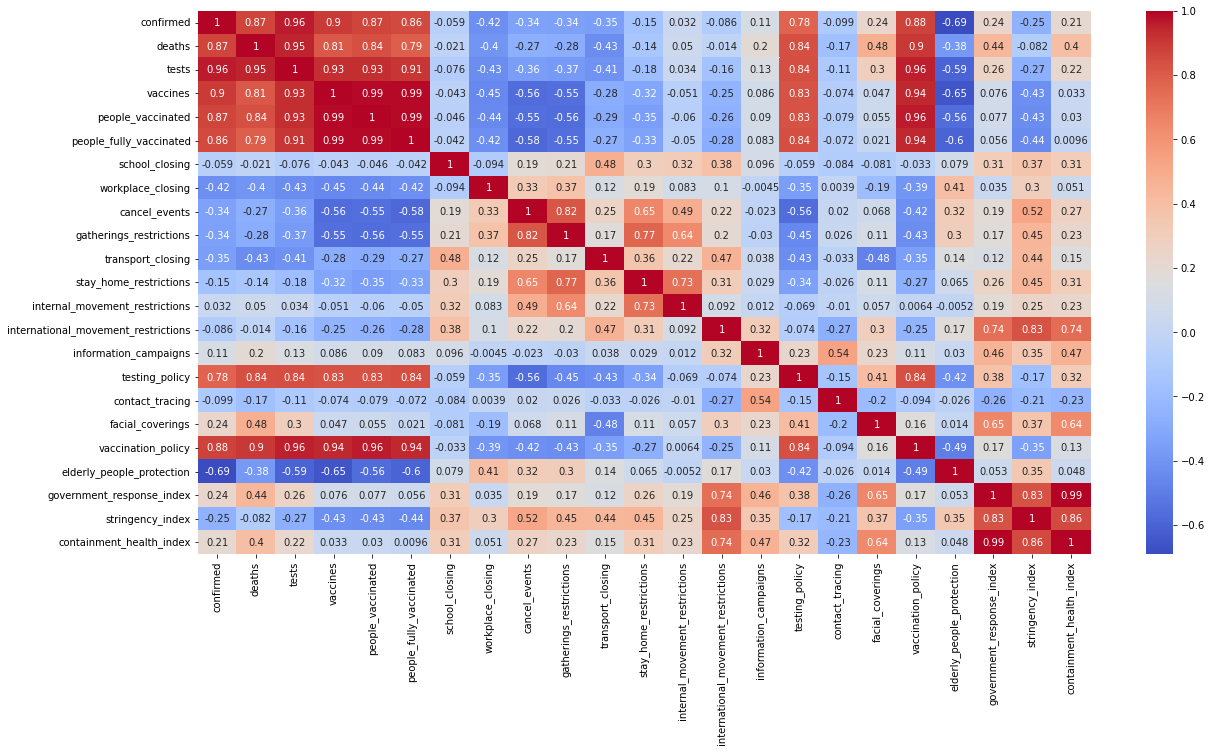

In [25]:
spain_corr = spain.corr()

figure = plt.figure(figsize=(20, 10))
sns.heatmap(spain_corr, annot=True, cmap= 'coolwarm')
plt.show()

Do tworzenia wstępnych modeli postanowiłem użyć zmiennych dla których wartość bezwględna współczynnika korelacji z interesującymi nas kolumnami (confirmed, deaths oraz z opóźnieniami) wynosiła co najmniej 0.4

In [70]:
confirmed_explanatory = [
    'deaths',
    'tests',
    'vaccines',
    'people_vaccinated',
    'people_fully_vaccinated',
    'workplace_closing',
    'testing_policy',
    'vaccination_policy',
    'elderly_people_protection'
]

deaths_explanatory = [
    'confirmed',
    'tests',
    'vaccines',
    'people_vaccinated',
    'people_fully_vaccinated',
    'workplace_closing',
    'transport_closing',
    'testing_policy',
    'facial_coverings',
    'vaccination_policy',
    'government_response_index',
    'containment_health_index'
]

# 4. Modelowanie liczby potwierdzonych przypadków (Hiszpania)

### 4.1 Regresja liniowa

In [27]:
models_confirmed_1 = pd.DataFrame(index=[confirmed_explanatory], columns = ['R2 train', 'R2 test', 'RMSE train', 'RMSE test', 'p train', 'p test'])

In [28]:
x_train, x_test, y_train, y_test = train_test_split(spain[confirmed_explanatory], spain[["confirmed"]],
                                            test_size=0.2, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegr

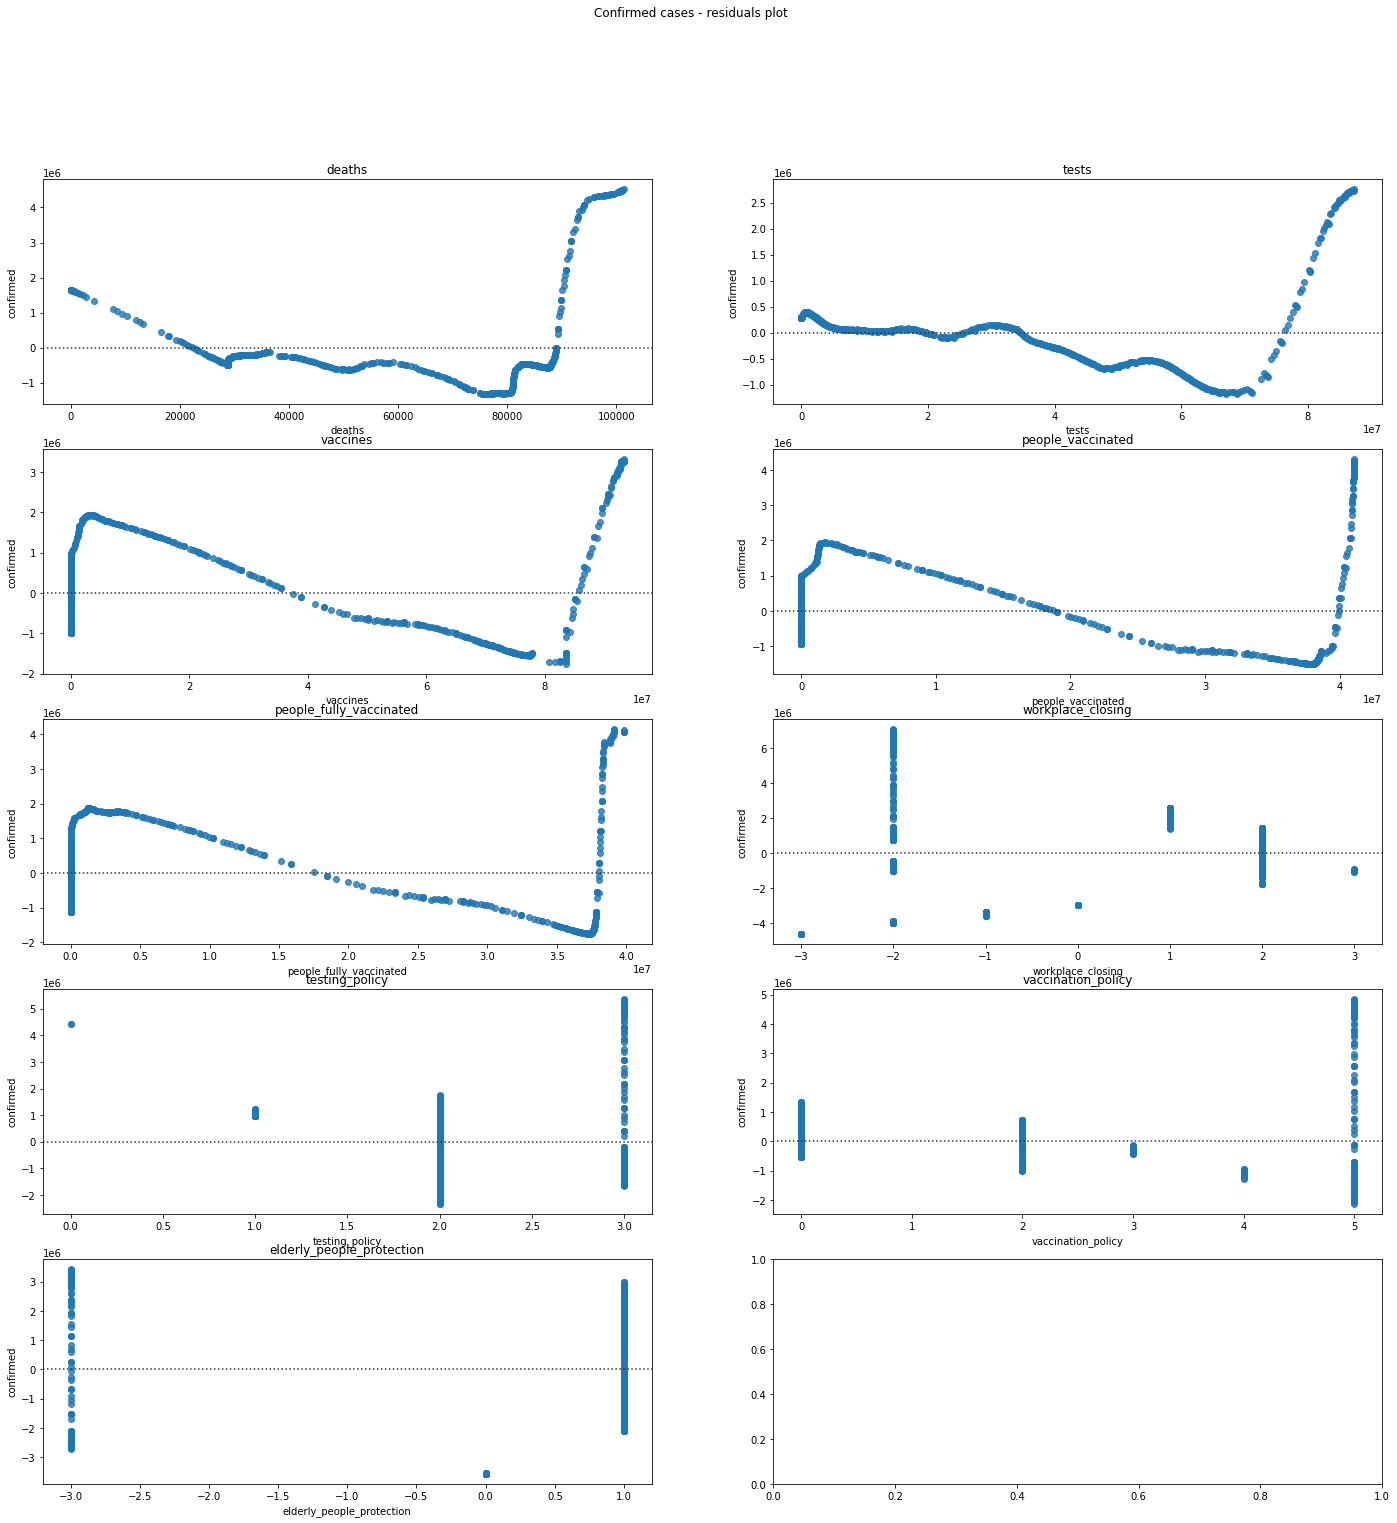

,R2 train,R2 test,RMSE train,RMSE test,p train,p test
deaths,0.768352,0.748135,1385603.651664,1419477.773974,0.0,0.0
tests,0.927107,0.923593,777262.199256,781826.701178,0.0,0.0
vaccines,0.811422,0.804235,1250172.19859,1251445.387221,0.0,0.0
people_vaccinated,0.764611,0.749688,1396747.752511,1415095.01376,0.0,0.0
people_fully_vaccinated,0.737038,0.728539,1476287.734608,1473662.52458,0.0,0.0
workplace_closing,0.157542,0.253456,2642402.210768,2443838.793596,0.0,0.0
testing_policy,0.608061,0.605293,1802327.397386,1776978.097527,0.0,0.0
vaccination_policy,0.773143,0.764125,1371200.79731,1373680.540724,0.0,0.0
elderly_people_protection,0.47726,0.47887,2081458.190498,2041821.566443,0.0,0.0


In [30]:
fig, ax = plt.subplots(5, 2, figsize=(24,24))
fig.suptitle('Confirmed cases - residuals plot')

for idx, col in enumerate(confirmed_explanatory):
    reg = LinearRegression()

    reg.fit(np.array(x_train[[col]], dtype = np.float64).reshape(-1, 1), y_train)

    pred_train = reg.predict(np.array(x_train[col]).reshape(-1,1))
    pred_test = reg.predict(np.array(x_test[col]).reshape(-1,1))

    r2_train = reg.score(x_train[[col]], y_train)
    r2_test = reg.score(x_test[[col]], y_test)
    rmse_train = np.sqrt(mse(y_train, pred_train))
    rmse_test = np.sqrt(mse(y_test, pred_test))

    residuals_train = y_train - pred_train
    stat_train, p_train = shapiro(residuals_train)

    residuals_test = y_test - pred_test
    stat_test, p_test = shapiro(residuals_test)

    models_confirmed_1.iloc[idx, :] = [r2_train, r2_test, rmse_train, rmse_test, p_train, p_test]

    m = idx // 2
    n = idx % 2
    sns.residplot(ax=ax[m,n], x=x_train[col], y=y_train['confirmed'])
    ax[m, n].set_title(col)

plt.show()
models_confirmed_1

**PODSUMOWANIE MODELU**

### 4.2 Regresja wieloraka

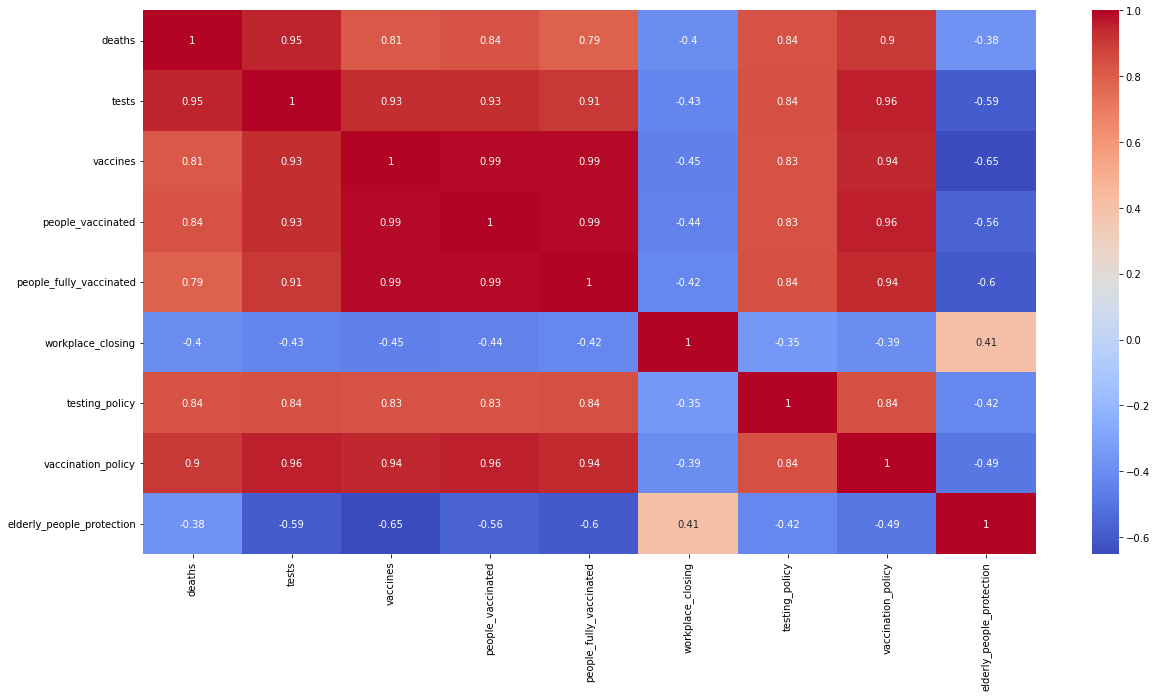

In [32]:
figure = plt.figure(figsize=(20, 10))
sns.heatmap(spain[confirmed_explanatory].corr(), annot=True, cmap= 'coolwarm')
plt.show()

Wszystkie zmienne za wyjątkiem 'elderly_people_protection' i 'workplace_closing' mają wzajemną korelację oraz korelajcę ze zmienną 'tests' powyżej 0.8. Dlatego tych dwóch użyjemy do tworzenia modeli regresji wielorakiej, ponieważ ich wzajemny współczynnik korelacji wynosi 0.41 więc nie są współliniowe.

In [39]:
cols = ['tests', 'elderly_people_protection', 'workplace_closing']

In [35]:
print(f"Magnituda: \ntests: {np.min(spain['tests'])} - {np.max(spain['tests'])}\
      \nelderly_people_protecion: {np.min(spain['elderly_people_protection'])} - {np.max(spain['elderly_people_protection'])}\
      \nworkplace_closing: {np.min(spain['workplace_closing'])} - {np.max(spain['workplace_closing'])}")

Magnitude 
tests: 0.0 - 87336414.0      
elderly_people_protecion: -3.0 - 1.0      
workplace_closing: -3.0 - 3.0


Zmienne różnią się magnitudą więc przeprowadzamy standaryzację.

In [40]:
scaler = StandardScaler()
x_train_scal = scaler.fit_transform(x_train[cols])
x_test_scal = scaler.transform(x_test[cols])

Utworzymy 3 modele regresji wielorakiej, gdzie jako zmiennych wyjaśniajacych użyjemy:
- 1. tests + elderly_people_protection
- 2. tests + workplace_closing
- 3. tests + elderly_people_protection + workplace_closing

In [52]:
explanatory_variables = [ [0, 1], [0, 2], [0, 1, 2]]

In [59]:
models_confirmed_2 = pd.DataFrame(index=range(1,4), columns = ['R2 train', 'R2 test', 'RMSE train', 'RMSE test'])

for idx, vars in enumerate(explanatory_variables):
  model = LinearRegression()

  model.fit(x_train_scal[:, vars], y_train)
  pred_train = model.predict(x_train_scal[:, vars])
  pred_test = model.predict(x_test_scal[:, vars])

  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

  rmse_train = np.sqrt(mse(y_train, pred_train))
  rmse_test = np.sqrt(mse(y_test, pred_test))

  models_confirmed_2.iloc[idx, :] = [r2_train, r2_test, rmse_train, rmse_test]

models_confirmed_2

,R2 train,R2 test,RMSE train,RMSE test
1,0.94754,0.952999,659382.285751,613193.028452
2,0.927262,0.923475,776437.132087,782430.237615
3,0.947933,0.95369,656911.992564,608669.97936


### 4.3 Drzewa regresyjne

In [62]:
models_confirmed_3 = pd.DataFrame(index=range(1,4), columns = ['R2 train', 'R2 test', 'RMSE train', 'RMSE test'])

for idx, vars in enumerate(explanatory_variables):
  model = DecisionTreeRegressor()

  model.fit(x_train_scal[:, vars], y_train)
  pred_train = model.predict(x_train_scal[:, vars])
  pred_test = model.predict(x_test_scal[:, vars])

  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

  rmse_train = np.sqrt(mse(y_train, pred_train))
  rmse_test = np.sqrt(mse(y_test, pred_test))

  models_confirmed_3.iloc[idx, :] = [r2_train, r2_test, rmse_train, rmse_test]

models_confirmed_3

,R2 train,R2 test,RMSE train,RMSE test
1,1.0,0.9999,0.172485,28265.273
2,1.0,0.9999,0.172485,28265.273
3,1.0,0.9999,0.172485,28316.915933


### 4.4 Random Forest

In [64]:
models_confirmed_4 = pd.DataFrame(index=range(1,4), columns = ['R2 train', 'R2 test', 'RMSE train', 'RMSE test'])

for idx, vars in enumerate(explanatory_variables):
  model = RandomForestClassifier()

  model.fit(x_train_scal[:, vars], y_train['confirmed'])
  pred_train = model.predict(x_train_scal[:, vars])
  pred_test = model.predict(x_test_scal[:, vars])

  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

  rmse_train = np.sqrt(mse(y_train, pred_train))
  rmse_test = np.sqrt(mse(y_test, pred_test))

  models_confirmed_4.iloc[idx, :] = [r2_train, r2_test, rmse_train, rmse_test]

models_confirmed_4

,R2 train,R2 test,RMSE train,RMSE test
1,1.0,0.9999,0.249401,28265.273001
2,1.0,0.9999,0.249401,28316.915934
3,1.0,0.9999,0.249401,28316.915934


### 4.5 SVM

In [67]:
models_confirmed_5 = pd.DataFrame(index=range(1,4), columns = ['R2 train', 'R2 test', 'RMSE train', 'RMSE test'])

for idx, vars in enumerate(explanatory_variables):
  model = svm.SVC(kernel='linear')

  model.fit(x_train_scal[:, vars], y_train['confirmed'])
  pred_train = model.predict(x_train_scal[:, vars])
  pred_test = model.predict(x_test_scal[:, vars])

  r2_train = r2_score(y_train, pred_train)
  r2_test = r2_score(y_test, pred_test)

  rmse_train = np.sqrt(mse(y_train, pred_train))
  rmse_test = np.sqrt(mse(y_test, pred_test))

  models_confirmed_5.iloc[idx, :] = [r2_train, r2_test, rmse_train, rmse_test]

models_confirmed_5

,R2 train,R2 test,RMSE train,RMSE test
1,0.829214,0.814386,1189737.574106,1218568.131094
2,0.822615,0.80684,1212504.664213,1243090.577653
3,0.82212,0.806659,1214194.071339,1243674.740402


## PODSUMOWANIE HISZPANIA CONFIMRED

# 5. Modelowanie liczby zgonów (Hiszpania)

### 5.1 Regresja liniowa

In [82]:
models_deaths_1 = pd.DataFrame(index=[deaths_explanatory], columns = ['R2 train', 'R2 test', 'RMSE train', 'RMSE test', 'p train', 'p test'])

In [71]:
x_train, x_test, y_train, y_test = train_test_split(spain[deaths_explanatory], spain[["deaths"]],
                                            test_size=0.2, random_state=42)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LinearRegr

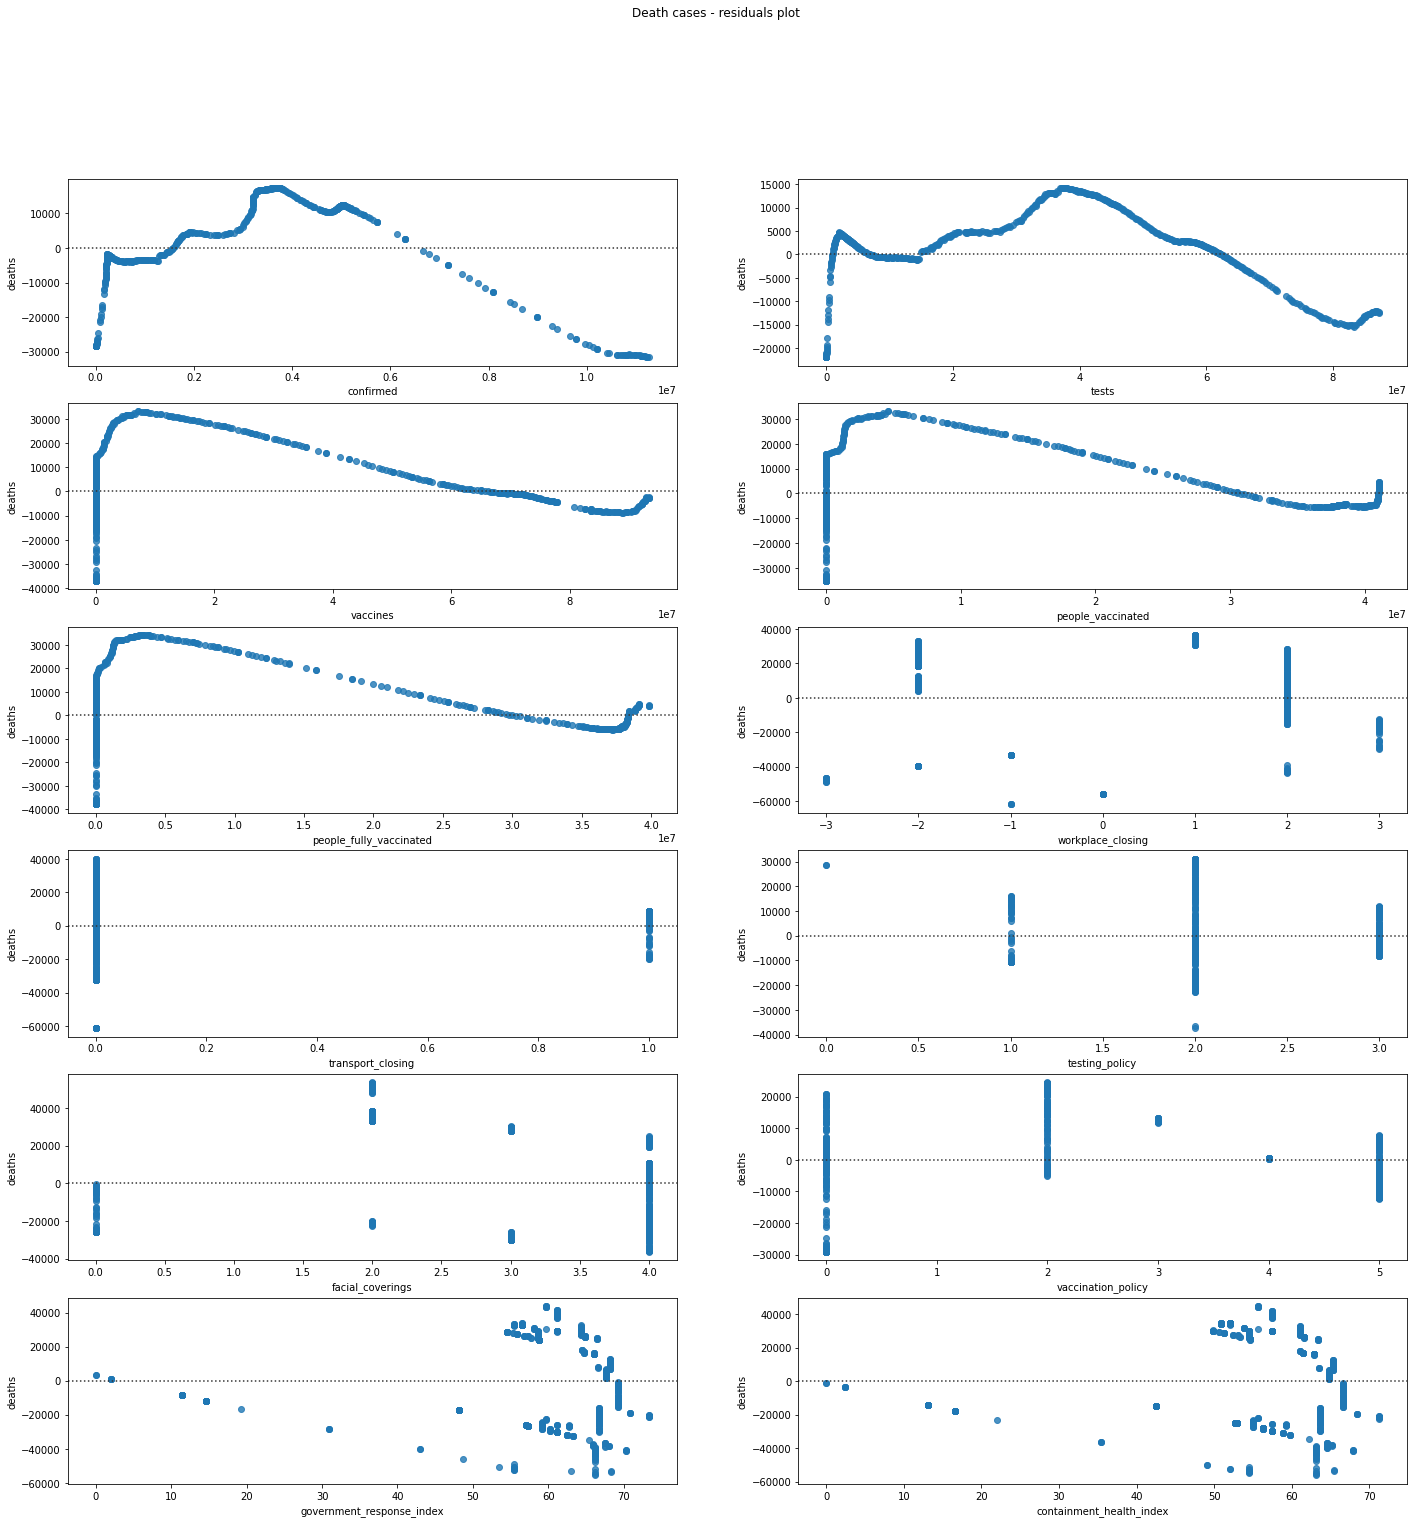

,R2 train,R2 test,RMSE train,RMSE test,p train,p test
confirmed,0.768352,0.748876,14681.096066,15288.751196,0.0,0.0
tests,0.900609,0.896404,9616.521767,9819.741297,0.0,0.0
vaccines,0.668796,0.634011,17554.632689,18457.007937,0.0,0.000023
people_vaccinated,0.709646,0.677832,16436.453851,17316.853616,0.0,0.000004
people_fully_vaccinated,0.635075,0.598061,18426.623076,19342.27512,0.0,0.000016
workplace_closing,0.140526,0.233728,28278.764295,26706.61736,0.0,0.0
transport_closing,0.174607,0.233082,27712.432931,26717.872337,0.0,0.0
testing_policy,0.705114,0.669952,16564.215723,17527.342977,0.0,0.000006
facial_coverings,0.216097,0.286014,27006.929012,25779.370424,0.0,0.0
vaccination_policy,0.822461,0.802422,12852.608932,13561.169897,0.0,0.000032


In [81]:
fig, ax = plt.subplots(6, 2, figsize=(24,24))
fig.suptitle('Death cases - residuals plot')

for idx, col in enumerate(deaths_explanatory):
    reg = LinearRegression()

    reg.fit(np.array(x_train[[col]], dtype = np.float64).reshape(-1, 1), y_train)

    pred_train = reg.predict(np.array(x_train[col]).reshape(-1,1))
    pred_test = reg.predict(np.array(x_test[col]).reshape(-1,1))

    r2_train = reg.score(x_train[[col]], y_train)
    r2_test = reg.score(x_test[[col]], y_test)
    rmse_train = np.sqrt(mse(y_train, pred_train))
    rmse_test = np.sqrt(mse(y_test, pred_test))

    residuals_train = y_train - pred_train
    stat_train, p_train = shapiro(residuals_train)

    residuals_test = y_test - pred_test
    stat_test, p_test = shapiro(residuals_test)

    models_deaths_1.iloc[idx, :] = [r2_train, r2_test, rmse_train, rmse_test, p_train, p_test]

    m = idx // 2
    n = idx % 2
    sns.residplot(ax=ax[m,n], x=x_train[col], y=y_train['deaths'])

plt.show()
models_deaths_1

### 5.2 Regresja wieloraka

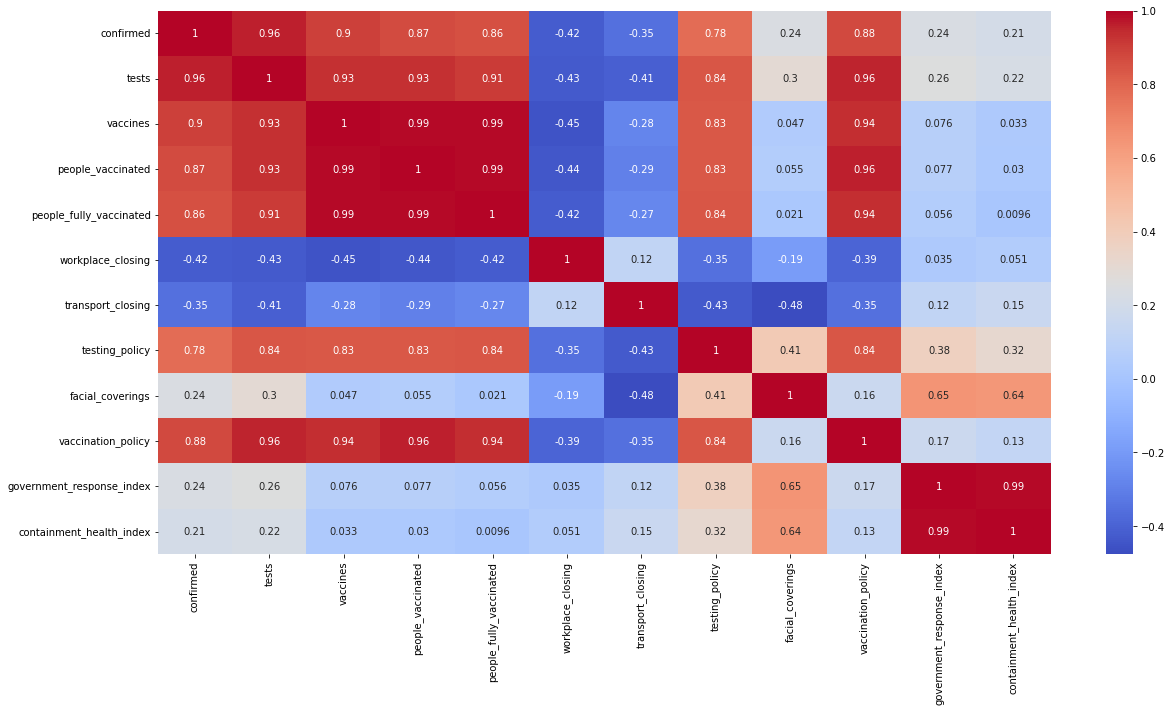

In [84]:
figure = plt.figure(figsize=(20, 10))
sns.heatmap(spain[deaths_explanatory].corr(), annot=True, cmap= 'coolwarm')
plt.show()

W regresji liniowej najlepsze parametry ponownie uzyskał model dla zmiennej 'tests'. Do regresji wielorakiej wybieramy więc zmienne, które nie są skorelowane z testami. Zauważam przy tym, że zmienna 'facial_coverings' jest skorelowana ze zmiennymi opsiującymi indeksy, jak również z transport_closing. Zatem do regresji wielorakiej wybieram zmienne 'tests', 'facial_coverings' i 'workplace_closing'.

5.3 Utworzenie pozostałych klasyfikatorów

In [86]:
cols = ['tests', 'facial_coverings', 'workplace_closing']

print(f"Magnituda: \ntests: {np.min(spain['tests'])} - {np.max(spain['tests'])}\
      \nfacial_coverings: {np.min(spain['facial_coverings'])} - {np.max(spain['facial_coverings'])}\
      \nworkplace_closing: {np.min(spain['workplace_closing'])} - {np.max(spain['workplace_closing'])}")

Magnituda: 
tests: 0.0 - 87336414.0      
facial_coverings: 0.0 - 4.0      
workplace_closing: -3.0 - 3.0


In [87]:
scaler = StandardScaler()
x_train_scal = scaler.fit_transform(x_train[cols])
x_test_scal = scaler.transform(x_test[cols])

In [94]:
explanatory_variables = [ [0, 1], [0, 2], [0, 1, 2]]

classifiers = {
    'MLR': LinearRegression(),
    'DTR': DecisionTreeRegressor(),
    'RF': RandomForestClassifier(),
    'SVM': svm.SVC(kernel='linear')
}

models_deaths = {}

In [95]:
for name, model in classifiers.items():
  models = pd.DataFrame(index=range(1,4), columns = ['vars', 'R2 train', 'R2 test', 'RMSE train', 'RMSE test'])
  models['vars'] = [
    'tests + facial_coverings',
    'tests + workplace_closing',
    'tests + facial_coverings + workplace_closing'
  ]
  for idx, vars in enumerate(explanatory_variables):
    model.fit(x_train_scal[:, vars], y_train)
    pred_train = model.predict(x_train_scal[:, vars])
    pred_test = model.predict(x_test_scal[:, vars])

    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)

    rmse_train = np.sqrt(mse(y_train, pred_train))
    rmse_test = np.sqrt(mse(y_test, pred_test))

    models.iloc[idx, 1:] = [r2_train, r2_test, rmse_train, rmse_test]

  models_deaths[name] = models.copy()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=T

### 5.4 Wyniki

In [104]:
models_deaths['MLR']

,vars,R2 train,R2 test,RMSE train,RMSE test
1,tests + facial_coverings,0.941883,0.943964,7353.531381,7222.089479
2,tests + workplace_closing,0.90064,0.896448,9615.022525,9817.651393
3,tests + facial_coverings + workplace_closing,0.942313,0.944633,7326.277677,7178.837662


In [105]:
models_deaths['DTR']

,vars,R2 train,R2 test,RMSE train,RMSE test
1,tests + facial_coverings,1.0,0.999893,0.0,314.867862
2,tests + workplace_closing,1.0,0.999897,0.0,309.596429
3,tests + facial_coverings + workplace_closing,1.0,0.999862,0.0,359.026373


In [106]:
models_deaths['RF']

,vars,R2 train,R2 test,RMSE train,RMSE test
1,tests + facial_coverings,1.0,0.999893,11.900974,314.867862
2,tests + workplace_closing,1.0,0.999865,0.0,354.827041
3,tests + facial_coverings + workplace_closing,1.0,0.999864,0.0,355.241248


In [107]:
models_deaths['SVM']

,vars,R2 train,R2 test,RMSE train,RMSE test
1,tests + facial_coverings,0.941994,0.928474,7346.508476,8159.404395
2,tests + workplace_closing,0.932177,0.922475,7943.88643,8494.722936
3,tests + facial_coverings + workplace_closing,0.959351,0.956449,6149.948336,6366.870129


# 6. Usunięcie braków danych (świat)

In [109]:
test_nan = world['tests'].isna().groupby(world['administrative_area_level_1']).mean()
test_nan

administrative_area_level_1
Afghanistan             0.996437
Albania                 0.157957
Algeria                 0.998812
American Samoa          1.000000
Andorra                 0.909631
                          ...   
Virgin Islands, U.S.    1.000000
Wallis and Futuna       1.000000
Yemen                   0.997622
Zambia                  0.109264
Zimbabwe                0.211653
Name: tests, Length: 236, dtype: float64

Jest pewna grupa krajów dla których występują braki danych w kolumnie testów dochodzące do 100%. Dlatego niemożliwe jest przeprowadzenie sensownej analizy na całym zbiorze danych. Jeśli nie wiemy ile testów zostało wykonanych, pozostałe dane są również mało wiarygodne. Dedycuduję się na wyrzucenenie ze zbioru krajów które mają braki danych w kolumnie testów powyżej 50%.

In [112]:
good_testers = list(test_nan[test_nan < 0.5].index)
world = world[world['administrative_area_level_1'].isin(good_testers)]

In [114]:
100 * world.isnull().sum() / world.shape[0]

date                                    0.000000
confirmed                               4.319125
deaths                                  6.910128
recovered                              51.649142
tests                                  15.372737
vaccines                               61.269332
people_vaccinated                      62.469351
people_fully_vaccinated                64.208082
school_closing                          8.666541
workplace_closing                       8.707799
cancel_events                           8.710157
gatherings_restrictions                 8.717229
transport_closing                       8.719587
stay_home_restrictions                  8.726660
internal_movement_restrictions          8.697190
international_movement_restrictions     8.687759
information_campaigns                   8.737269
testing_policy                          8.706620
contact_tracing                         8.699547
facial_coverings                        8.743163
vaccination_policy  

Podobnie jak w przypadku Hiszpanii, w skali globalnej wiele krajów również zaprzestało prowadzenia statystyk odnośnie ozdrowieńców. Braki danych w tej kolumnie wynoszą 51.6%, dlatego decyduję się na jej usunięcie.

In [116]:
world = world.drop('recovered', axis=1)

Na etapie wstępnej eksploracji danych uznałem, że ciężko będzie w efektywny sposób uzupełnić brakujące wartości w skali globalnej, ponieważ w różnych krajach w różnych momentach rozpoczynała się epidemia, szczepienia, różnie przeprowadzano testy. W związku z tym w celu wyczyszczenia danych, posłużymy się grupowaniem po państwach i dla każdej takiej grupy wykonamy proces podobny jak w przypadku czyszczenia danych dla Hiszpanii, z pewnymi modyfikacjami.

In [117]:
world_by_countries = [y for x, y in world.groupby('administrative_area_level_1', as_index=False)]

### 6.1 Uzupełnienie zerami danych z początku pandemii (potwierdzone przypadki, zgony i dane o szczepionkach)

In [121]:
cumulative_cols = ['vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'confirmed', 'deaths']

In [118]:
for country_df in world_by_countries:
    country_df[cumulative_cols] = country_df[cumulative_cols].interpolate('zero', fill_value=0, limit_direction='backward')

### 6.2 Pozbycie się ewentualnych błędów w monotoniczności dla danych skumulowanych

In [119]:
for country_df in world_by_countries:
    columns_with_error = []

    for col in cols:
        a = np.array(country_df[col].dropna())
        if not np.all(a[:-1] <= a[1:]):
            columns_with_error.append(col)

    for col in columns_with_error:
        a = np.array(country_df[col])
        for i in range(1, country_df.shape[0]):
            if a[i] < a[i-1]:
                a[i] = a[i-1]
        country_df[col] = a

### 6.3 Usunięcie państw o wysokim poziomie braków danych
Sprawdzamy ile zostało braków, usuwamy z dalszych rozważań państwa które mają wysoki współczynnik braków danych pomimo przeprowadzonych wcześniej operacji:

In [120]:
countries_to_delete = []
for i, country_df in enumerate(world_by_countries):
    nan_ratio = (country_df.isnull().sum() / country_df.shape[0]).mean()
    if nan_ratio > 0.6:
        countries_to_delete.append(i)

countries_to_delete.sort()
for index in sorted(countries_to_delete, reverse=True):
    del world_by_countries[index]

### 6.4 Interpolacja wartości skumulowanych

In [122]:
for i, country_df in enumerate(world_by_countries):
    country_df[cumulative_cols] = country_df[cumulative_cols].interpolate('linear')
    world_by_countries[i] = country_df

### 6.5 Usunięcie państw dla których braki danych o szczepieniach wynoszą 100%

In [123]:
countries_to_delete = []
for i, country_df in enumerate(world_by_countries):
    vaccine_nulls_ratio = (100 * country_df[vaccine_cols].isnull().sum() / country_df.shape[0]).sum() / len(vaccine_cols)
    if vaccine_nulls_ratio == 100:
        countries_to_delete.append(i)
print(countries_to_delete)

for idx in reversed(countries_to_delete):
    del world_by_countries[idx]

[33, 68]


### 6.6 Uzupełnienie testów z początku pandemii odpowiednim współczynnikiem oraz interpolacja pozostałych brakujących wartości

In [124]:
for k, country_df in enumerate(world_by_countries):
    # Uzupełnienie z początku pandemii
    country_df = country_df.reset_index(drop=True)
    i = country_df.tests.first_valid_index()
    a = country_df['tests'][i:i+14]
    b = country_df['confirmed'][i:i+14]
    ratio = np.divide(a, b, out=np.zeros_like(a), where=b!=0 )
    mean_ratio = max(ratio.mean(), 1)
    country_df.loc[:i,'tests'] = (country_df['confirmed'][:i+1] * mean_ratio).astype(int)
    # Interpolacja pozostałych wartości
    country_df['tests'] = country_df['tests'].interpolate('linear')

    world_by_countries[k] = country_df

#### 6.7 Usunięcie braków w kolumnach odpowiadających za poziom restrykcji
Okazuje się, że w przypadku danych globalnych również mamy do czynienia z sytuacją, gdzie braki danych w kolumnach dotyczących restrykcji i polityki antycovidowej występują od pewnego zadanego dnia. Jednak ten dzień, będzie za każdym razem inny, w zależności od państwa. Nie możemy więc na sztywno podać daty od której usuniemy obserwacje, tak jak to zrobiliśmy w przypadku danych lokalnych.
Zamiast tego, zdecydowałem się znaleźć taki przedział czasowy, dla którego większość krajów nie prowadziła już tych statystyk, ale jednocześnie mieć na uwadze aby przedział ten nie zaczynał się zbyt wcześnie, bo skutkowałoby to utratą cennych informacji z innych kolumn. Usuwając obserwacje jedynie z końca pandemii, zachowamy również jednolitą rozdzielczość próbkowania dla całego okresu (codziennie). W tym celu, z każdego kraju weźmiemy pierwszy dzień w którym te braki zaczynają występować i sprawdzimy jaki jest rozkład tego wskaźnika dla wszystkich krajów.

In [125]:
first_null= []
for country_df in world_by_countries:
    nulls = country_df[country_df['cancel_events'].isnull()].index.tolist()
    if nulls:
        first_null.append(nulls[0])
print(f"Mediana: {np.median(first_null)}, Średnia: {np.mean(first_null)}")

Mediana: 832.0, Średnia: 821.8555555555556


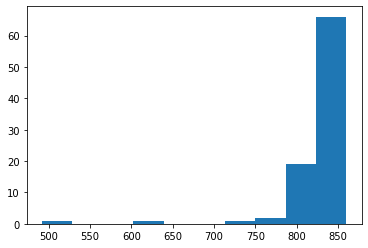

In [126]:
plt.hist(first_null)
plt.show()

Jak widać, poza dwoma wyjątkami, kraje zaczynają przestawać raportować dane o restrykcjach po 700. dniu pandemii. Przyjrzyjmy się bliżej temu okresowi.

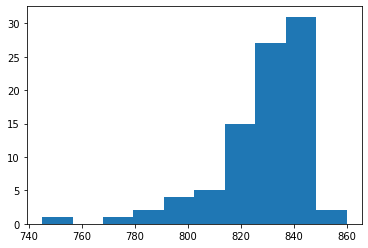

In [127]:
first_null = np.array(first_null)
first_null = first_null[first_null > 700]
plt.hist(first_null)
plt.show()

Po przeanalizowaniu histogramu widać, że zdecydowana większość państw przestaje raportować w okolicy 815-820 dnia, co dobrze obrazuje obliczona wartość średnia. Dlatego nie będziemy brać pod uwagę obserwacji po tym dniu, a pozostałe (wcześniejsze) uzupełnimy ostatnią znaną wartością.

In [132]:
restriction_cols = world_by_countries[0].columns[7:-1]
for i, country_df in enumerate(world_by_countries):
    df_cut = country_df.drop(country_df.index[int(np.mean(first_null)):])
    df_cut[restriction_cols] = df_cut[restriction_cols].ffill()
    world_by_countries[i] = df_cut

### 6.8 Ponowne złączenie w jeden dataframe

In [140]:
world = pd.concat(world_by_countries)
world = world.drop('administrative_area_level_1', axis=1)

In [141]:
100 * world.isnull().sum() / world.shape[0]

date                                   0.0
confirmed                              0.0
deaths                                 0.0
tests                                  0.0
vaccines                               0.0
people_vaccinated                      0.0
people_fully_vaccinated                0.0
school_closing                         0.0
workplace_closing                      0.0
cancel_events                          0.0
gatherings_restrictions                0.0
transport_closing                      0.0
stay_home_restrictions                 0.0
internal_movement_restrictions         0.0
international_movement_restrictions    0.0
information_campaigns                  0.0
testing_policy                         0.0
contact_tracing                        0.0
facial_coverings                       0.0
vaccination_policy                     0.0
elderly_people_protection              0.0
government_response_index              0.0
stringency_index                       0.0
containment

In [137]:
print(f"Po czyszczeniu zachowano {100 * world.shape[0] / raw_data_shape[0]}% obserwacji")

Po czyszczeniu zachowano 100.0% obserwacji


W ten sposób pozbyliśmy się brakujących wartości z danych globalnych.

# 7. Przygotowanie danych (świat)

Ponieważ chcemy analizować globalnie, należy tak przetworzyć nasz zbiór danych, aby informacje z wszystkich państw dla danego dnia zgrupować do jednej obserwacji. W przypadku danych skumulowanych, funkcją agregującą będzie suma. Dla zmiennych kategorycznych, policzymy wartość średnią i zaokrąglimy ją do najbliższej liczby całkowitej, opisującej poziom restrykcji.

In [142]:
logic = {
    'confirmed': 'sum',
    'deaths': 'sum',
    'tests': 'sum',
    'vaccines': 'sum',
    'people_vaccinated': 'sum',
    'people_fully_vaccinated': 'sum',
    'school_closing': 'mean',
    'workplace_closing': 'mean',
    'cancel_events': 'mean',
    'gatherings_restrictions': 'mean',
    'transport_closing': 'mean',
    'stay_home_restrictions': 'mean',
    'internal_movement_restrictions': 'mean',
    'international_movement_restrictions': 'mean',
    'information_campaigns': 'mean',
    'testing_policy': 'mean',
    'contact_tracing': 'mean',
    'facial_coverings': 'mean',
    'vaccination_policy': 'mean',
    'elderly_people_protection': 'mean',
    'government_response_index': 'mean',
    'stringency_index': 'mean',
    'containment_health_index': 'mean',
}

In [143]:
world = world.groupby('date').agg(logic)

In [148]:
categorical_cols = world.columns[6:-3]
world[categorical_cols] = world[categorical_cols].round(0)

Otrzymaliśmy dane globalne pogrupowane po datach, a więc możemy przejść do tworzenia modeli.